In [1]:
from datetime import datetime, timezone, timedelta
from collections import defaultdict
from io import BytesIO

import requests
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def request_usgs(days=60, radius_km=100, lat=36.423348523921334, long=25.428376651549783) -> pd.DataFrame:
    base_url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
    now = datetime.utcnow()
    start_time = now - timedelta(days=days)
    params = {
        "format": "csv",
        "starttime": str(start_time),
        "endtime": str(now),
        "latitude": lat,
        "longitude": long,
        "maxradiuskm": radius_km,
    }
    resp = requests.get(url=base_url, params=params)
    resp.raise_for_status()
    return pd.read_csv(BytesIO(resp.content))

In [3]:
def mag_hist(df, bin_width=timedelta(days=1), total_days=60, radius_km=100, today=False, figsize=(8, 5)):
    # Hard code magnitude buckets
    mag_buckets = [(0, 3), (3, 3.5), (3.5, 4), (4, 4.5), (4.5, 5), (5, 5.5), (5.5, 6), (6, 100)]
    colors = ["whitesmoke", "royalblue", "lightgreen", "gold", "darkorange", "tomato", "darkred", "black"]

    # Extract just the dates and magnitudes of each event
    dates = [datetime.fromisoformat(d[:-1]).astimezone(timezone.utc) for d in df.time]
    magnitudes = list(df.mag)

    # Group by magnitude
    data_by_bucket = defaultdict(list)
    for date, mag in zip(dates, magnitudes):
        for bucket in mag_buckets:
            if bucket[0] < mag <= bucket[1]:
                # data_by_bucket[bucket].append((mdates.date2num(date), mag))
                data_by_bucket[bucket].append((date, mag))

    # Get the exact bins based on the given bin width
    today = datetime.utcnow().date()
    bins = []
    current_bin = today - timedelta(days=total_days)
    while current_bin <= today:
        bins.append(current_bin)
        current_bin += bin_width

    plt.figure(figsize=figsize)
    for bucket, color in zip(mag_buckets, colors):
        data_points = data_by_bucket[bucket]
        if len(data_points) == 0:
            continue
        bucket_dates, bucket_mags = zip(*data_points)
        plt.hist(bucket_dates, bins=bins, label=f"{bucket[0]}-{bucket[1]}", color=color)
    
    if today:
        plt.axvline(x=today, color='black', linestyle='--', label='Today', alpha=0.75)
    plt.legend(loc="best")
    plt.xticks(rotation=60)
    plt.ylabel("Count")
    plt.title(f"Earthquakes <{radius_km}km from Fira Over the Last {total_days} Days")

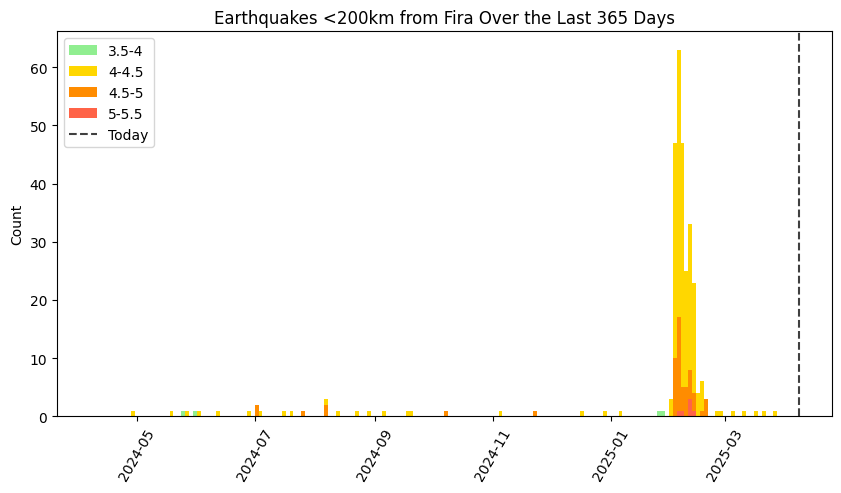

In [4]:
days = 365
width = 2
radius_km = 200
figsize = (10, 5)
include_today = True
df = request_usgs(days=days, radius_km=radius_km)
mag_hist(df, bin_width=timedelta(days=width), total_days=days, radius_km=radius_km, today=include_today, figsize=figsize)